<a href="https://colab.research.google.com/github/ekity1002/DL4US_homeworks/blob/master/Experiment_resnet2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os

import tensorflow.keras as keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Input, Activation, add, Add, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split, StratifiedKFold

SEED = 2019

In [0]:
def load_cifar10():
    
    # 学習データ
    # x_train = np.load('/root/userspace/public/lesson2/data/x_train.npy')
    # y_train = np.load('/root/userspace/public/lesson2/data/y_train.npy')
    x_train = np.load('/content/drive/My Drive/Colab Notebooks/x_train.npy')
    y_train = np.load('/content/drive/My Drive/Colab Notebooks/y_train.npy')
    # テストデータ
    # x_test = np.load('/root/userspace/public/lesson2/data/x_test.npy')
    x_test = np.load('/content/drive/My Drive/Colab Notebooks/x_test.npy')
    
    x_train = x_train / 255.
    x_test = x_test / 255.

    # 平均値を引く
    subtract_pixel_mean = True
    if subtract_pixel_mean:
        x_train_mean = np.mean(x_train, axis=0)
        x_train -= x_train_mean
        x_test -= x_train_mean
        
    y_train = np.eye(10)[y_train]    
    return (x_train, x_test, y_train)

x_train, x_test, y_train = load_cifar10()

In [0]:
# 水増し用ジェネレータ定義
def my_generator(x, y, batch_size):
    gen_params = {
        'rotation_range':20,
        'horizontal_flip':True,
        'height_shift_range':0.2,
        'width_shift_range':0.2,
        'zoom_range':0.2,
        'channel_shift_range':0.2
    }
    img_gen = ImageDataGenerator(**gen_params)
    for x_batch, y_batch in img_gen.flow(x,y,batch_size=batch_size):
        yield x_batch, y_batch
        
def tta(model, test_size, generator, batch_size ,epochs=10):
    # test_time_augmentation 予測画像を水増しし、多数決を取る。
    # batch_sizeは，test_sizeの約数でないといけない．
    pred = np.zeros(shape = (test_size,10), dtype=float)
    step_per_epoch = test_size // batch_size #1バッジに使うテストデータの量
    for epoch in range(epochs):
        for step in range(step_per_epoch):
            sta = batch_size * step #バッジの先頭のデータのテストデータにおけるインデックス ?
            end = sta + batch_size  # バッジ終了のテストデータのインデックス
            tmp_x = generator.__next__() #予測画像をbatch_size だけ生成
            #print("tmpx : ", tmp_x.shape)
            pred[sta:end] += model.predict(tmp_x)

    return pred / epochs


def tta_generator(x_test, batch_size):
    """tta用 予測画像水増し用ジェネレータ"""
    return ImageDataGenerator(rotation_range = 20 , horizontal_flip = True,height_shift_range = 0.2,\
                                 width_shift_range = 0.2,zoom_range = 0.2,channel_shift_range = 0.2\
                                  ).flow(x_test, batch_size = batch_size,shuffle = False)

In [0]:
def plot_acc_and_loss(history):
    """plot history"""
    fig, ax = plt.subplots(1,2, figsize=(15, 5))
    
    acc = history.history['acc']
    val_acc = history.history['val_acc']    
    epochs=range(1, len(acc)+1)    
    ax[0].plot(epochs, acc, label='Train')
    ax[0].plot(epochs, val_acc, label='Val')
    ax[0].legend()
    ax[0].set_title('Accuracy')
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs=range(1, len(loss)+1)
    ax[1].plot(epochs, loss, label='Train')
    ax[1].plot(epochs, val_loss, label='Val')
    ax[1].set_xlim(0, 5)
    ax[1].legend()
    ax[1].set_title('Loss')
    plt.show()

In [0]:
def _shortcut(x, residual):
    
    n_filters = int(residual.shape[-1]) #チャネル数
    
    # inputs と residual のチャネル数が違ったときのため 1x1 Conv で
    # residual 側のフィルタ数にする
    shortcut = Conv2D(n_filters, (1,1), strides=(1,1), padding='valid')(x)
    
    return add([shortcut, residual])

def resblock(filters1, filters2, strides=(1,1)):
    """
    filters1 : ボトルネック チャネル数
    filters2 : 出力チャネル数
    """
    def f(input):
        """Bottleneck アーキテクチャ"""
        x = Conv2D(filters1, (1,1), padding='same', strides=strides, kernel_initializer='he_normal')(input)
        x = Activation('relu')(x)
        x = Conv2D(filters1, (3,3), padding='same', strides=strides, kernel_initializer='he_normal')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2D(filters2, (1,1), padding='same', strides=strides, kernel_initializer='he_normal')(x)
        return _shortcut(input, x)
    return f

def build_model():
    drop_rate=0.3
    inp = Input(shape = (32,32,3))
    x = Conv2D(64, (7,7), strides=(1,1),
               kernel_initializer='he_normal', padding='same')(inp)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2,2), padding='same')(x)

    x = resblock(64, 256)(x)
    x = resblock(64, 256)(x)
    x = resblock(64, 256)(x)
    x = MaxPooling2D()(x)

    x = resblock(128, 512)(x)
    x = resblock(128, 512)(x)
    x = resblock(128, 512)(x)
    x = MaxPooling2D()(x)

    x = resblock(256, 1024)(x)
    x = resblock(256, 1024)(x)
    x = resblock(256, 1024)(x)
    x = MaxPooling2D()(x)

    x = resblock(512, 2048)(x)
    x = resblock(512, 2048)(x)
    x = resblock(512, 2048)(x)
    x = GlobalAveragePooling2D()(x)


    x = Dense(2048,activation = "relu",  kernel_initializer='he_normal')(x)
    x = Dropout(drop_rate)(x)
    x = Dense(516,activation = "relu",  kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Dense(1024,activation = "relu",  kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    out  = Dense(10, activation="softmax")(x)

    return Model(inputs=inp, outputs=out)

In [0]:
model = build_model()
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

X_trn, X_val, y_trn, y_val = train_test_split(x_train, y_train, random_state=SEED, stratify=y_train)
batch_size = 2000
epochs = 1000
steps_per_epoch = X_trn.shape[0] // batch_size
validation_steps = X_val.shape[0] // batch_size
callbacks = [EarlyStopping(patience=30),
             ReduceLROnPlateau(patience=15, factor=0.2),
             #LearningRateScheduler(lr_schedule),
             #ModelCheckpoint(filepath='/root/userspace/lesson2/model_1.hdf5', monitor='val_acc', save_best_only=True)
            ]

#train_gen = ImageDataGenerator().flow(X_trn, y_trn, batch_size)
val_gen = ImageDataGenerator().flow(X_val, y_val, batch_size)

history = model.fit_generator(my_generator(X_trn, y_trn, batch_size),
                    steps_per_epoch=len(X_trn)//batch_size,
                    epochs=epochs,
                    validation_data=my_generator(X_val, y_val, batch_size),
                    validation_steps=len(X_val)//batch_size,
                    callbacks=callbacks,
                    verbose=2)
#model.fit(x=x_train, y=y_train, batch_size=700, epochs=150, validation_split=0.1)

y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, 1)
submission = pd.Series(y_pred, name='label')
submission.to_csv('submission_expresnet2.csv', header=True, index_label='id')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Epoch 1/1000
Epoch 1/1000
18/18 - 124s - loss: 2.3788 - acc: 0.1895 - val_loss: 79.6363 - val_acc: 0.1217
Epoch 2/1000
Epoch 1/1000
18/18 - 108s - loss: 1.9712 - acc: 0.2403 - val_loss: 4.0049 - val_acc: 0.1697
Epoch 3/1000
Epoch 1/1000
18/18 - 79s - loss: 1.8439 - acc: 0.2756 - val_loss: 4.3618 - val_acc: 0.1575
Epoch 4/1000
Epoch 1/1000
18/18 - 79s - loss: 1.7749 - acc: 0.3024 - val_loss: 3.5753 - val_acc: 0.1564
Epoch 5/1000
Epoch 1/1000
18/18 - 79s - loss: 1.7110 - acc: 0.3341 - val_loss: 3.4835 - val_acc: 0.1431
Epoch 6/1000
Epoch 1/1000
18/18 - 79s - loss: 1.6741 - acc: 0.3477 - val_loss: 3.2443 - val_acc: 0.1186
Epoch 7/1000
Epoch 1/1000
18/18 - 79s - loss: 1.6267 - acc: 0.3775 - val_loss: 2.6973 - val_acc: 0.1390
Epoch 8/1000
Epoch 1/1000
18/18 - 79s - loss: 1.5616 - acc: 0.4079 - val_loss: 3.3612 - val_acc: 0.1049
Epoch 9/1000
Epoch 1/1000
18/18 - 78s - loss: 1.4941 - acc: 0.4299 - val_loss: 3.248

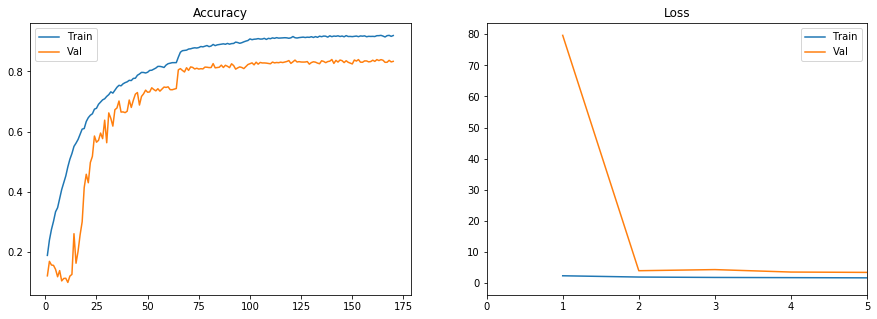

In [0]:
plot_acc_and_loss(history)

In [0]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 64)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [0]:
!cp submission_expresnet.csv "/content/drive/My Drive/Colab Notebooks/"

cp: cannot stat 'submission_expresnet.csv': No such file or directory


In [0]:
%%time
# try tta
tta_epochs = 50
tta_pred = tta(model, x_test.shape[0], tta_generator(x_test, batch_size=1000), batch_size=1000, epochs=tta_epochs)
print(tta_pred.shape)
print(tta_pred)

In [0]:
tta_pred = np.argmax(tta_pred, axis=1)
submission = pd.Series(tta_pred, name='label')
submission.to_csv('tta_submission2.csv', header=True, index_label='id')

In [0]:
!cp tta_submission.csv "/content/drive/My Drive/Colab Notebooks/"

In [0]:
model = load_model('model.hdf5')